## JWST NIRSpec data reduction

This notebook was adopted from the JWST Data Analysis and Processing Workshop, Thailand. And created by Dr. Themiya Nanayakkara.

Workshop website: https://indico.narit.or.th/event/203/overview

Dr. Themiya Nanayakkara: https://experts.swinburne.edu.au/1781-themiya-nanayakkara

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

import astropy.units as u
import astropy.io.fits as pyfits

import mastquery.utils
import mastquery.jwst

from grizli import utils
import msaexp.slit_combine
import msaexp.spectrum
import msaexp
from msaexp import pipeline

import glob
import asdf

print('msaexp version: ', msaexp.__version__)

msaexp version:  0.8.5


# Finding objects of interest

Before getting into various steps of the NIRSpec data reduction first lets look at how we can plan some science with data in the archive. 

Imagine that you are intersted in studying the formation of massive galaxies in the early Universe. In our current cosmological models galaxies grow via hierachichal merging. To test the formation and evolution of galaxies we can try to find the most massive quiescent galaxies that are formed in the first ~2 billion years of the Universe. 

You do a literature search and find the first massive quiescent galaxies that was spectrscopically confirmed at z>3. The galaxy is presented in Glazebrook+2017 https://ui.adsabs.harvard.edu/abs/2017Natur.544...71G/abstract 

This was done before JWST was operational. The data is from the MOSFIRE instrument in the Keck Telescopes and only covers the K band. You want to see whether someone has obtained a JWST spectrum of this galaxy and use it for your science. 


**Exercise:**
Go to MAST website https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html and find if there are any observations.

## Checking data through grizli

You can also use the services provided by DJA https://dawn-cph.github.io/dja/index.html to perfom this serach.

In [5]:
# Find the program, source_id based on a particular position
ra, dec = 150.06149, 2.3787093 ## 20115

slits_url = f"https://grizli-cutout.herokuapp.com/nirspec_slits?coord={ra},{dec}"
slits = utils.read_catalog(slits_url, format='csv')

slits['program','msametfl','source_id','grating','footprint'][slits['is_source'] == 'True']

program,msametfl,source_id,grating,footprint
int64,str25,int64,str5,str89
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061523,2.378754),(150.061543,2.378693),(150.061414,2.378649),(150.061394,2.378710))"
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061519,2.378754),(150.061539,2.378693),(150.061411,2.378649),(150.061390,2.378711))"
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061526,2.378754),(150.061547,2.378693),(150.061418,2.378649),(150.061398,2.378710))"
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061438,2.378670),(150.061411,2.378730),(150.061540,2.378784),(150.061566,2.378724))"
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061435,2.378670),(150.061409,2.378730),(150.061537,2.378784),(150.061564,2.378724))"
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061441,2.378670),(150.061414,2.378730),(150.061543,2.378784),(150.061569,2.378724))"


OK so there are multiple observations of the source by 2 different programs

Let us now first check the footprint of the data.

(-0.5, 239.5, 239.5, -0.5)

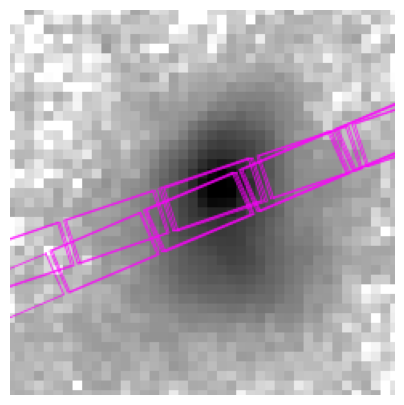

In [3]:
import PIL
import urllib

# Cutout figure
cutout_url = f"https://grizli-cutout.herokuapp.com/thumb?size=1&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra},{dec}&nirspec=True&dpi_scale=6&nrs_source=magenta&nrs_other=magenta&nrs_lw=0.5&nrs_alpha=0.8"

img = np.array(PIL.Image.open(urllib.request.urlopen(cutout_url)))

fig, ax = plt.subplots(1,1,figsize=(5,5))
_ = ax.imshow(img[::-1,:,:])
ax.axis('off')

So the object is observed but we need to look into details a bit more.  

**Exercise:**


1. Go to DJA website and find the galaxy
2. Figure out which program has public data
3. Use the APT and ALADIN to visualize the galaxy and objects. Specifically look for where the trace of the primary object of interest falls, any contamination probelms, and what the exposure time specifications are.



After this steps you should have a good general understanding on navigating various platforms to learn about the data. i.e. observing modes,  exposure times, settings used by the observers etc. 

Check if there are any public data availble for this galaxy.

Yes! They are publicly available!

Now we are ready to start looking at the spectral data.

# Download Stage 1 data products

We shall do the reductions ourselves first to obtain a better quality spectrum. For that, we will start with Stage 2 data products from MAST. 


We will skip downloading *uncal.fits files (Stage 1 data products) because they are very big. You can find them in /lustre/JDAP/jdap_data/nirspec_mos/data. 



In [4]:
prog =  2565
detectors = ['nrs1', 'nrs2']
gratings = ['prism']
mask_query = mastquery.jwst.make_query_filter('visit_id', values=['02565007001'])


# Query NIRSpec data for a program name
masks = pipeline.query_program(prog,
    download=True,
    detectors=detectors,
    gratings=gratings,
    product='rate', #include 'uncal' here if you want to get the Stage 0 data products (to run stage 1 of the pipeline)
    extra_filters=mask_query, 
)

files = glob.glob(f'jw0{prog}*rate.fits')

print(files)

['jw02565007001_03101_00002_nrs2_rate.fits', 'jw02565007001_03101_00004_nrs1_rate.fits', 'jw02565007001_03101_00004_nrs2_rate.fits', 'jw02565007001_03101_00002_nrs1_rate.fits', 'jw02565007001_03101_00003_nrs1_rate.fits', 'jw02565007001_03101_00003_nrs2_rate.fits']


# Reducing NIRSpec MOS data using the JWST Calibration Pipeline

This is a very direct workflow of the pipeline. All changes to the pipleine steps are handled through the `config_file's. 

Important to check what steps can be multiprocessed etc. 

The pipeline stages are documented here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html

In [5]:
os.environ['CRDS_PATH'] = os.path.expanduser('../../crds_cache')
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [6]:
# import os

# os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
# os.environ['CRDS_PATH'] = '/home/ahmad/SSA_2025/crds_cache'
# os.environ['CRDS_CONTEXT'] = 'jwst_1253.pmap'

# !crds bestrefs -s 1 -f /home/ahmad/SSA_2025/*.fits

# MSA meta data file

Key information about the MOS observations are stored in this file. 
Read about the file here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html


Because we are only interested in one object (for now in order to save time) we will edit the file so the pipleine will only process that object.

If you only have one object in a list and the trace only falls in one detector, for Stage 2 and 3 you need to only use the detector where the object is included. If you have the other detector the peipline will produce an error.  

In [7]:
from astropy.io import fits
from astropy.table import Table

In [8]:
meta_data_file_name = 'jw02565007001_01_msa_original.fits' #note that "_original" is a suffix that is not recognized by the pipeline.

In [9]:
gal_id =  20115 ## name the source we are interested in

In [10]:

meta_file = fits.open(meta_data_file_name)


msa_metadata_source_info = Table.read(meta_data_file_name, hdu=3).to_pandas()
msa_metadata_slit_info = Table.read(meta_data_file_name, hdu=2).to_pandas()

msa_metadata_source_info = msa_metadata_source_info[msa_metadata_source_info['source_id']==gal_id]

msa_metadata_source_info['stellarity'] = 1.0


meta_file['SOURCE_INFO'] =fits.BinTableHDU(Table.from_pandas(msa_metadata_source_info), name='SOURCE_INFO')

msa_metadata_slit_info = msa_metadata_slit_info.query('slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[0]) + '| slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[1]) +  ' | slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[2]))


meta_file['SHUTTER_INFO'] =fits.BinTableHDU(Table.from_pandas(msa_metadata_slit_info), name='SHUTTER_INFO')

print("Source info", meta_file['SOURCE_INFO'].data)
print("Shutter info", meta_file['SHUTTER_INFO'].data)

meta_data_file_name_new = meta_data_file_name.replace('msa_original', 'msa')

meta_file.writeto(meta_data_file_name_new, overwrite=True)

Source info [(2565, 20115, '2565_20115', '20115', 150.06146711, 2.37868632, 'None', 1.)]
Shutter info [(30, 1, 2, 138, 108,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 108,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 108, 20115, 'N', 'OPEN', 0.73 , 0.506, 2, 'Y')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 110,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 110,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 110, 20115, 'N', 'OPEN', 0.713, 0.529, 1, 'Y')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 112,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 112,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (

# STAGE 1

Works in detector space. We will use stage 2 data products from MAST and skip this step for now but the overall process is similar. 


We will skip running Stage 1 of the pipeline for the workshop because it takes a long time. 

**Exercise**
- Because we are skipping the Stage 1 of the pipleine, go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html to make sure you understand what steps are performed. Now how common Stage 1 is between NIRSpec and other instruments.
- Open one of the *.uncal files in ds9 or QfitsView and see if you can understand how the data is stored.



In [11]:
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
output_dir = './'
det1 = Detector1Pipeline()

det_param_reffile = os.path.join(output_dir, 'manual_calwebb_det1.asdf')

2025-09-11 08:10:55,061 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-09-11 08:10:55,064 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-09-11 08:10:55,066 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-09-11 08:10:55,071 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-09-11 08:10:55,073 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2025-09-11 08:10:55,076 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2025-09-11 08:10:55,078 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2025-09-11 08:10:55,082 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2025-09-11 08:10:55,084 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-09-11 08:10:55,087 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-09-11 08:10

Export the asdf file and manually edit as needed

In [12]:
if os.path.exists(det_param_reffile):
    print(det_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    det1.export_config(det_param_reffile)

./manual_calwebb_det1.asdf  file is already in directory. It will not be overwritten


Some steps can also be manually changed within the python objects. However, lets stick to editing the .asdf file directly, so there is no confusion about what setting has the highest priority. 

Get all uncal.fits files. We will feed them into the pipeline to be reduced one at a time. 

In [13]:
level0_data_files = glob.glob(output_dir+'*uncal.fits')
level0_data_files.sort()
level0_data_files

print('files to execute', level0_data_files)

files to execute []


In [14]:
for fits_image in level0_data_files:
    det1.call(fits_image, config_file=det_param_reffile, output_dir=output_dir)

# STAGE 2

Now you already have the *rate.fits files. Open all of them and check the data and err images to see if you detect anything abnormal. 
Check NIRSpec known issues https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues#gsc.tab=0 and also NIRSpec MOS known issues to see if you spot anything https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#gsc.tab=0 . 


In [15]:
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

In [16]:
output_dir = "./"
spec2 = Spec2Pipeline()
spec2_param_reffile = os.path.join(output_dir, 'manual_calwebb_spec2.asdf')

2025-09-11 08:11:00,706 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-09-11 08:11:00,711 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-09-11 08:11:00,714 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-09-11 08:11:00,717 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2025-09-11 08:11:00,720 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2025-09-11 08:11:00,722 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-09-11 08:11:00,725 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2025-09-11 08:11:00,727 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2025-09-11 08:11:00,733 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2025-09-11 08:11:00,735 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INF

In [17]:
if os.path.exists(spec2_param_reffile):
    print(spec2_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    spec2.export_config(spec2_param_reffile)


./manual_calwebb_spec2.asdf  file is already in directory. It will not be overwritten


We now have an association file. This will determine the node patterns etc. 
Check more information here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html

Then look at the .asn file for this stage to make sure all is good and is as expected. 

If everything is good we are ready for the data to be reduced

Make sure to ask the spec2 to save the results: 
save_results: true

In [18]:
%%time

spec2_asn_file = 'manual_calwebb2_asn.json'
result = spec2.call(spec2_asn_file, config_file=spec2_param_reffile)

2025-09-11 08:11:04,465 - CRDS - INFO -  Calibration SW Found: jwst 1.15.0 (/home/ahmad/miniconda3/envs/jwst_nirspec/lib/python3.11/site-packages/jwst-1.15.0.dist-info)
2025-09-11 08:11:04,467 - CRDS - INFO -  Server build context could not be identified. Using 'latest' instead.
2025-09-11 08:11:04,984 - CRDS - ERROR -  Error determining best reference for 'pars-badpixselfcalstep'  =   Unknown reference type 'pars-badpixselfcalstep'
2025-09-11 08:11:04,988 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2025-09-11 08:11:05,090 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-09-11 08:11:05,093 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-09-11 08:11:05,095 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-09-11 08:11:05,099 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2025-09-11 08:11:05,1

CPU times: user 2min 27s, sys: 3min 11s, total: 5min 39s
Wall time: 3min 50s


# STAGE 3

**Exercise:**
Go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html and read what steps will be run by the pipleine in Stage 2. 

In [19]:
from jwst.pipeline.calwebb_spec3 import Spec3Pipeline

In [20]:
spec3 = Spec3Pipeline()
output_dir = './'
spec3_param_reffile = os.path.join(output_dir, 'manual_calwebb_spec3.asdf')

2025-09-11 08:17:27,525 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-09-11 08:17:27,527 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-09-11 08:17:27,531 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2025-09-11 08:17:27,535 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2025-09-11 08:17:27,549 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-09-11 08:17:27,552 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-09-11 08:17:27,561 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2025-09-11 08:17:27,579 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-09-11 08:17:27,607 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-09-11 08:17:27,617 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep in

In [21]:
if os.path.exists(spec3_param_reffile):
    print(spec3_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    spec3.export_config(spec3_param_reffile)

./manual_calwebb_spec3.asdf  file is already in directory. It will not be overwritten


now again change params in asdf file so results are saved and remove the outlier detection steps and the 1d extraction (we will perform the latter seperately in a more optimal way).

In [22]:
#spec3.outlier_detection.skip = True ### the .asdf file seems to have higher priority now. so changes need to happen there

There is another association file for this step! Check the differences out

In [23]:
%%time

result = spec3.call(output_dir+ 'manual_calwebb3_asn.json' , save_results=True, 
                  config_file=spec3_param_reffile, output_dir=output_dir)

2025-09-11 08:17:31,862 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =    parameter='META.EXPOSURE.TYPE [EXP_TYPE]' value='NRS_MSASPEC' is not in ['NRS_IFU']
2025-09-11 08:17:31,882 - CRDS - ERROR -  Error determining best reference for 'pars-spectralleakstep'  =   Unknown reference type 'pars-spectralleakstep'
2025-09-11 08:17:31,935 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-09-11 08:17:31,939 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-09-11 08:17:31,942 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2025-09-11 08:17:31,945 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2025-09-11 08:17:31,950 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-09-11 08:17:31,952 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-09-11 08:17:31,957 - s

CPU times: user 24.9 s, sys: 5.54 s, total: 30.4 s
Wall time: 27.9 s


After this step the calibration pipleine is complete. You should have 2D and 1D (if you didn't skip that step) science products. 

The current calibration pipeline doesn't perfrom an optimal 1D extraction. So we will do that later on outside of the ST pipeline. 

# Check 2D pipleine outputs

You can use a software like QFitsView https://www.mpe.mpg.de/~ott/QFitsView/ and/or DS9 https://sites.google.com/cfa.harvard.edu/saoimageds9 to view the data products. 

They can also be opened up in python. I personally prefer to use a fits viewer instead.
Alwways check Stage 1,2,3 results to make sure no issues. We will focus on Stage 2 and 3 here.

## STAGE 2 products

In [24]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


In [25]:
cal_files = glob.glob('*cal.fits')
cal_files

['jw02565007001_03101_00003_nrs2_cal.fits',
 'jw02565-o007_s000020115_nirspec_clear-prism_cal.fits',
 'jw02565007001_03101_00002_nrs2_cal.fits',
 'jw02565007001_03101_00004_nrs2_cal.fits']

In [26]:
## check what is included
fits.open(cal_files[0]).info()

Filename: jw02565007001_03101_00003_nrs2_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  SCI           1 ImageHDU        95   (419, 38)   float32   
  2  DQ            1 ImageHDU        11   (419, 38)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        10   (419, 38)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (419, 38)   float32   
  5  BARSHADOW     1 ImageHDU         9   (419, 38)   float32   
  6  VAR_POISSON    1 ImageHDU         9   (419, 38)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (419, 38)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (419, 38)   float32   
  9  PATHLOSS_PS    1 ImageHDU         9   (419, 38)   float32   
 10  PATHLOSS_UN    1 ImageHDU         9   (419, 38)   float32   
 11  ASDF          1 BinTableHDU     11   1R x 1C   [135339B]   


In [27]:
### information about the reductions can be found in the headers
fits.open(cal_files[0])[0].header ### use 0, 1, 2 like index or names like 'SCI'



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2025-09-11T02:14:52.112' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw02565007001_03101_00003_nrs2_cal.fits' / Name of the file          
SDP_VER = '2023_4a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-065'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '8.5     '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        


Figure out the units of the flux measurements in the cal file

### plot the image

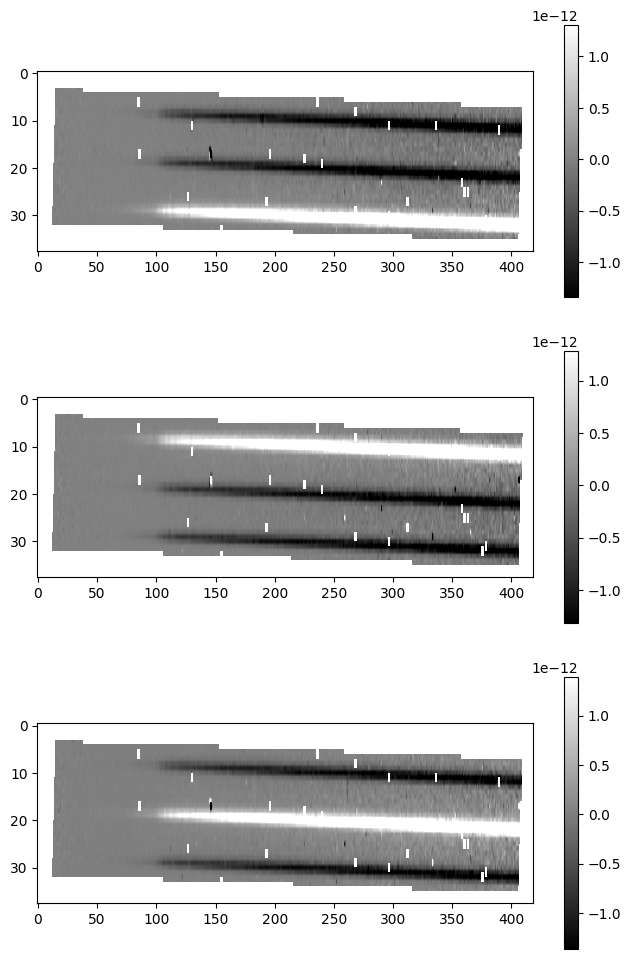

In [28]:
fig, axs = plt.subplots(nrows=3, figsize=(8,12))

axs.flatten()

for i in range(3):

    sci_image = fits.open(cal_files[i])['SCI'].data
    ### make in too like zscale in ds9 (can wipe out features so be careful)
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(sci_image)
    
    
    cax = axs[i].imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')
    
    fig.colorbar(cax, ax=axs[i], orientation='vertical', label='') ## add the units to the axis label



## STAGE 3 products

Go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html and read what steps will be run by the pipleine in Stage 3.

In [29]:
import glob
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


In [30]:
s2d_files = glob.glob('*s2d.fits')
s2d_files.sort(reverse=True) ### reverse the order so that we look at the intermediate s2d files first
s2d_files

['jw02565007001_03101_00004_nrs2_s2d.fits',
 'jw02565007001_03101_00003_nrs2_s2d.fits',
 'jw02565007001_03101_00002_nrs2_s2d.fits',
 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits']

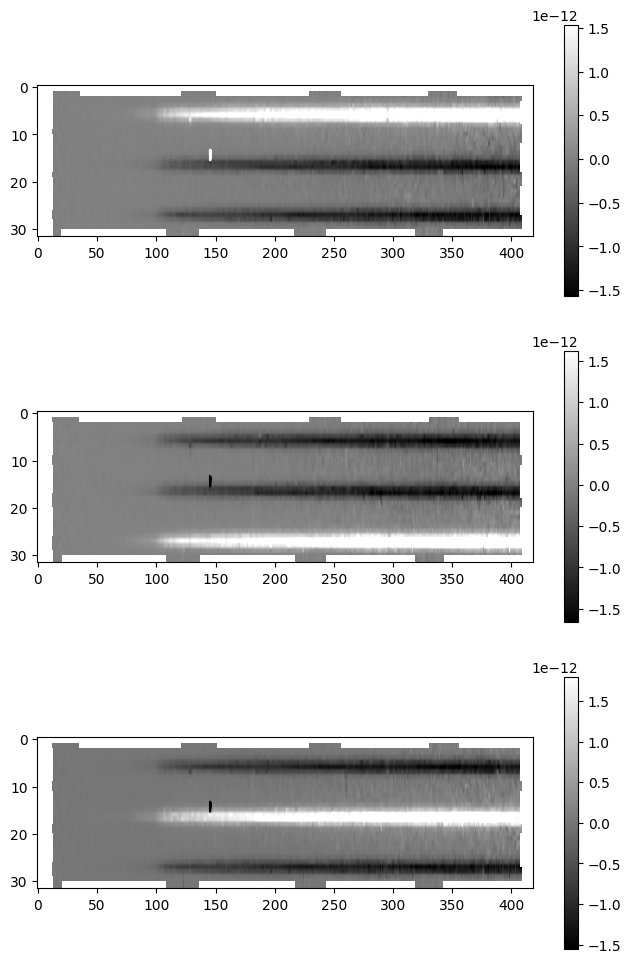

In [31]:
fig, axs = plt.subplots(nrows=3, figsize=(8,12))

axs.flatten()

for i in range(3):

    sci_image = fits.open(s2d_files[i])['SCI'].data
    ### make in too like zscale in ds9 (can wipe out features so be careful)
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(sci_image)
    
    
    cax = axs[i].imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')
    
    fig.colorbar(cax, ax=axs[i], orientation='vertical', label='') ## add the units to the axis label



#### Look at the final 2D combine frame

In [32]:
final_2d_combine_name = 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits'
fits.open(final_2d_combine_name).info()

Filename: jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     370   ()      
  1  SCI           1 ImageHDU        89   (419, 52)   float32   
  2  ERR           1 ImageHDU        10   (419, 52)   float32   
  3  WAVELENGTH    1 ImageHDU         9   (419, 52)   float32   
  4  WHT           1 ImageHDU         9   (419, 52)   float32   
  5  CON           1 ImageHDU        10   (419, 52, 1)   int32   
  6  VAR_POISSON    1 ImageHDU         9   (419, 52)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (419, 52)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (419, 52)   float32   
  9  HDRTAB        1 BinTableHDU    842   3R x 416C   [23A, 5A, 3A, 39A, 7A, 13A, 3A, 5A, 6A, 7A, 9A, 4A, L, D, D, D, D, 32A, 24A, 54A, 16A, 2A, D, 8A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 32A, 10A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 28A, 1A, 5A, D, D, D, D, D, D, D, D, 

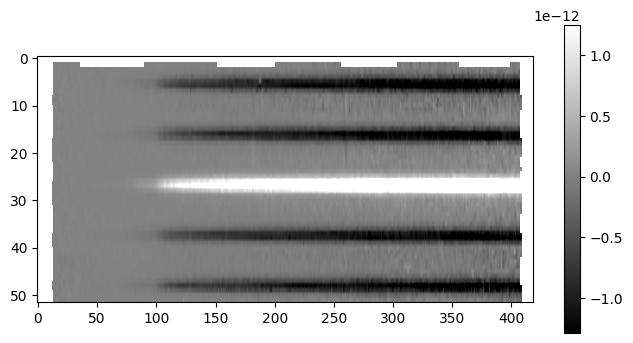

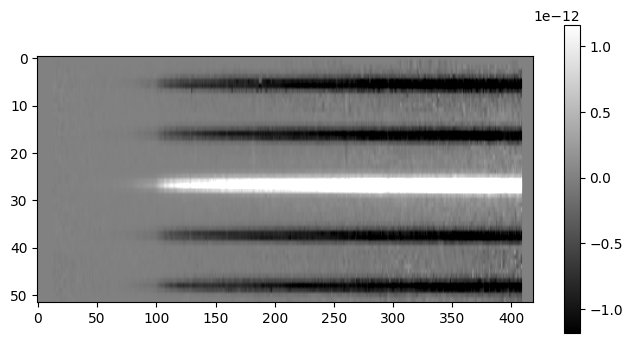

In [34]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))



sci_image = fits.open(final_2d_combine_name)['SCI'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label


#####################################
fig, axs = plt.subplots(nrows=1, figsize=(8,4))

compare = '../2-Extraction_1D/jw02565-o007_s20115_nirspec_clear-prism_s2d.fits'

sci_image = fits.open(compare)['SCI'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label



### Now look at the ERR and WHT arrays



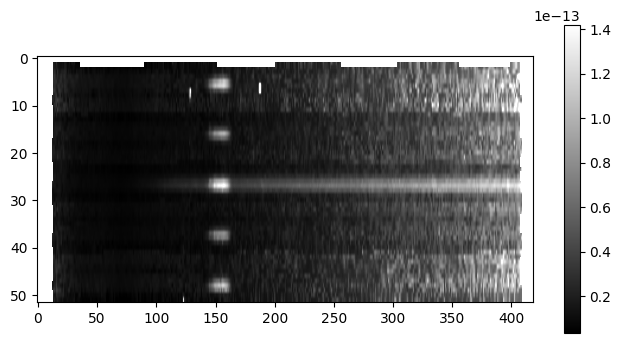

In [35]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))


sci_image = fits.open(final_2d_combine_name)['ERR'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label



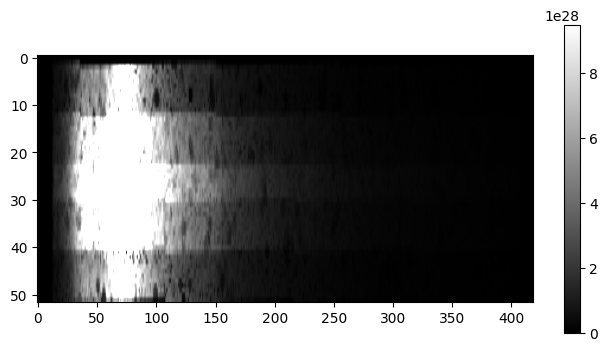

In [36]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))


sci_image = fits.open(final_2d_combine_name)['WHT'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label

